In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import random
from qiskit import (QuantumCircuit, QuantumRegister, ClassicalRegister)

from qiskit_aer import qasm_simulator
from qiskit_aer import AerSimulator
from qiskit_aer import QasmSimulator
from qiskit.circuit.library import MCMT
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mcx(qcoin[:]+qpos[i+1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        if i+1 < n: circuit.x(qpos[i+1:])
        circuit.mcx(qcoin[:]+qpos[i+1:], qpos[i], None, mode='noancilla')
        if i+1 < n: circuit.x(qpos[i+1:])
def num_to_binary(num, n):
    binary_str = ''
    while num > 0:
        if num % 2 == 0:
            binary_str = '0' + binary_str
        else:
            binary_str = '1' + binary_str
        num //= 2  
    while len(binary_str) < n:
        binary_str = '0' + binary_str
    
    return binary_str
def step(circuit, qpos, qcoin, cpos):
    circuit.h(qcoin)
    circuit.barrier()
    # y operations
    increment_gate(circuit, qpos[len(qpos)//2:], qcoin)
    circuit.x(qcoin[0])
    decrement_gate(circuit, qpos[len(qpos)//2:], qcoin)
    # x operations
    circuit.x(qcoin)
    increment_gate(circuit, qpos[:len(qpos)//2], qcoin)
    circuit.x(qcoin[0])
    decrement_gate(circuit, qpos[:len(qpos)//2:], qcoin)
    circuit.barrier()
   
def origin_converter_2d_x_n(circuit, origin, n):
    str = num_to_binary(origin[0], n)
    for i in range(0, n):
        if str[i] == '0':
            continue
        circuit.x(i)
    return circuit

def origin_converter_2d_y_n(circuit, origin, n):
    str = num_to_binary(origin[1], n)
    for i in range(0, n):
        if str[i] == '0':
            continue
        circuit.x(n + i)
    return circuit

       
def binary_to_num(str, n):
    str = str[::-1]
    sum = 0
    for i in range(0, n):
        if str[i] == '1':
            sum = sum + 2**i
        else:
            continue
    
    return sum

def probabilities_calc(circuit, origin, last_position, steps, qpos, qcoin, cpos, n):
    num = random.random()
    backend = QasmSimulator()
    if(steps == 0):
        return last_position
    for i in range(steps):
        step(circuit, qpos, qcoin, cpos)
    # # Map the quantum measurement to the classical bits
    circuit.measure(qpos,cpos)
    counts = backend.run(circuit, shots=1024).result().get_counts()
    state = list(counts.keys())
    count_dict = {}

    exp = 2**n

    for i in range(0, exp):
        for j in range(0, exp):
            count_dict[str(i) + ":" + str(j)] = 0

   
 
    for i in state:
        count_dict[str(binary_to_num(i[n:][::-1], n)) + ":" + str(binary_to_num(i[:n][::-1], n))] = counts[i]
   

    i = last_position[0]
    j = last_position[1]

    s1 =  count_dict[str(step_last_position_original[(i-1)%exp][j][0]) + ":" + str(step_last_position_original[(i-1)%exp][j][1])]
    s2 =  count_dict[str(step_last_position_original[i][(j-1)%exp][0]) + ":" + str(step_last_position_original[i][(j-1)%exp][1])]
    s3 =  count_dict[str(step_last_position_original[(i+1)%exp][j][0]) + ":" + str(step_last_position_original[(i+1)%exp][j][1])]
    s4 =  count_dict[str(step_last_position_original[i][(j+1)%exp][0]) + ":" + str(step_last_position_original[i][(j+1)%exp][1])]

   
    sum = s1 + s2 + s3 + s4

    p1 = s1/sum
    p2 = s2/sum
    p3 = s3/sum
    p4 = s4/sum

    list_prob = [p1, p2, p3, p4]

    list_prob_cumilative = [p1, p1 + p2, p1 + p2 + p3, p1 + p2 + p3 + p4]

    if(0<= num < list_prob_cumilative[0]):
        return [(i-1)%exp, j]

    elif(list_prob_cumilative[0] <= num < list_prob_cumilative[1]):
        return [i, (j-1)%exp]

    elif(list_prob_cumilative[1] <= num < list_prob_cumilative[2]):
        return [(i+1)%exp, j]

    elif(list_prob_cumilative[2] <= num < list_prob_cumilative[3]):
        return [i, (j+1)%exp]
   

def run_2d_n(origin, steps, last_position, step_last_position_2d, n):
    qpos = QuantumRegister(2*n,'qc')
    qcoin = QuantumRegister(2,'qanc')
    cpos = ClassicalRegister(2*n,'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)
    circuit = origin_converter_2d_x_n(circuit, origin, n)
    circuit = origin_converter_2d_y_n(circuit, origin, n)

    new_position = probabilities_calc(circuit, origin, last_position, steps, qpos, qcoin, cpos, n)
    step_last_position_2d[origin[0]][origin[1]] = new_position
    return new_position




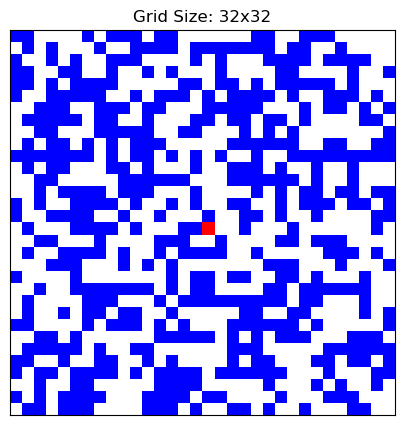

------------------ INITIAL -----------------------


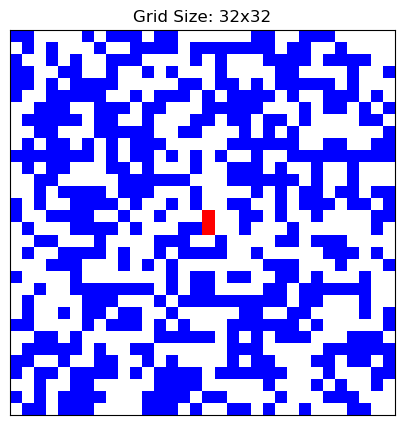

iteration: 1


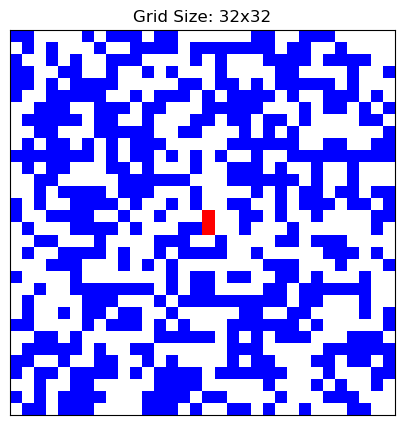

iteration: 2


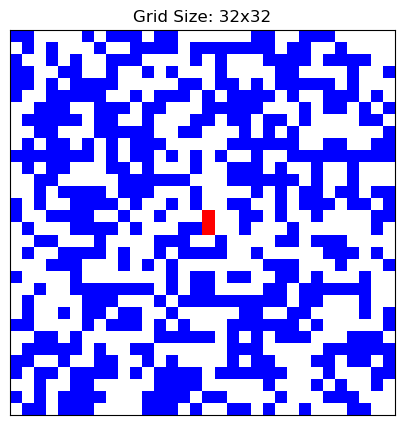

iteration: 3


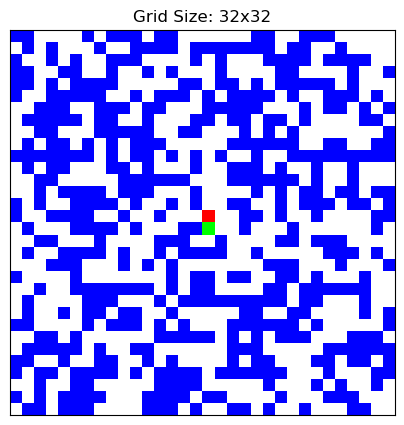

iteration: 4


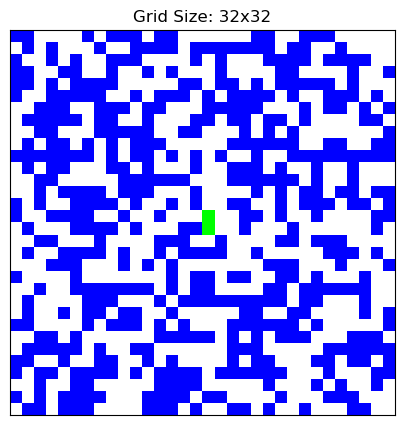

iteration: 5


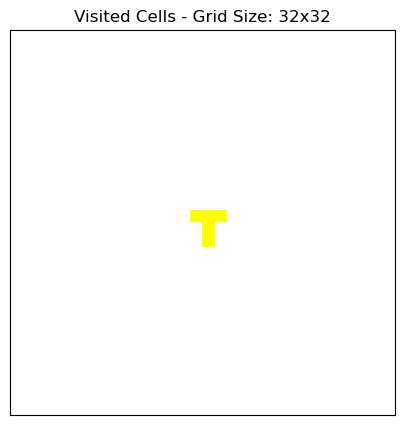

In [6]:
'''Provide probability(p), tau, number of susceptible agents(N) 
and number qubits(n) which dictates the lattice size'''
p = 0.9 

tau_max =3

n = 5
exp = 2**n

N = 500




check = [[0 for x in range(0, exp)] for y in range(0, exp)]

def create_matrix_with_ones(L, N):
    # Create an L*L matrix filled with zeros
    matrix = [[0 for _ in range(L)] for _ in range(L)]
   
    # Flattened index positions for the matrix
    all_positions = [(i, j) for i in range(L) for j in range(L)]
   
    # Randomly select N unique positions
    selected_positions = random.sample(all_positions, N)
   
    # Place ones at the selected positions
    for i, j in selected_positions:
        matrix[i][j] = 1
   
    return matrix

is_agent = create_matrix_with_ones(exp, N)


is_visited = [[0 for x in range(0, exp)] for y in range(0, exp)]
is_agent[int(exp/2)][int(exp/2)] = 1
check[int(exp/2)][int(exp/2)] = 1

step_last_position_2d = [[[0 for x in range(0, 2)] for y in range(0, exp)] for z in range(0, exp)]

for i in range(0, exp):
    for j in range(0, exp):
        step_last_position_2d[i][j][0] = i
        step_last_position_2d[i][j][1] = j

step_last_position_original = [[[0 for x in range(0, 2)] for y in range(0, exp)] for z in range(0, exp)]

for i in range(0, exp):
    for j in range(0, exp):
        step_last_position_original[i][j][0] = i
        step_last_position_original[i][j][1] = j



step_counter = [[0 for x in range(0, exp)] for y in range(0, exp)]


def check_if_all_zeros(check):
    for i in range(0, exp):
        for j in range(0, exp):
            if(check[i][j]==1):
                return False
    return True  

import matplotlib.pyplot as plt
import numpy as np

def plot_grid_improved(grid, is_agent, filename=None):
    """
    Show the grid image with plt.show() if filename is None or False (blocking).
    If filename is a non-empty string, save to file instead.
    """
    rows, cols = len(grid), len(grid[0])
    color_grid = np.zeros((rows, cols, 3), dtype=float)

    for i in range(rows):
        for j in range(cols):
            if grid[i][j] == 0:
                color_grid[i, j] = [0, 0, 1.0] if (is_agent is not None and is_agent[i][j] == 1) else [1.0, 1.0, 1.0]
            elif grid[i][j] == 1:
                color_grid[i, j] = [1.0, 0, 0]
            elif grid[i][j] == 2:
                color_grid[i, j] = [0, 1.0, 0]

    if isinstance(filename, str) and filename:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(color_grid, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Grid Size: {rows}x{cols}")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        return

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(color_grid, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Grid Size: {rows}x{cols}")
    plt.show()       
    plt.close(fig)


def plot_visited_improved(grid, filename=None):
    rows, cols = len(grid), len(grid[0])
    color_grid = np.zeros((rows, cols, 3), dtype=float)
    for i in range(rows):
        for j in range(cols):
            color_grid[i, j] = [1.0, 1.0, 0] if grid[i][j] == 1 else [1.0, 1.0, 1.0]

    if isinstance(filename, str) and filename:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(color_grid, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Visited Cells - Grid Size: {rows}x{cols}")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        return

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(color_grid, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Visited Cells - Grid Size: {rows}x{cols}")
    plt.show()       
    plt.close(fig)
   
def walker2d_1(check):
    iter = 0
    while not check_if_all_zeros(check):
        # update step counters and statuses
        for i in range(exp):
            for j in range(exp):
                if check[i][j] == 1:
                    if step_counter[i][j] == tau_max:
                        step_counter[i][j] = 0
                        step_last_position_2d[i][j] = step_last_position_original[i][j]
                        check[i][j] = 2
                    else:
                        step_counter[i][j] += 1

        # move walkers
        for i in range(exp):
            for j in range(exp):
                if check[i][j] == 1:
                    r_x_new, r_y_new = run_2d_n([i, j], step_counter[i][j], step_last_position_2d[i][j], step_last_position_2d, n)
                    is_visited[r_x_new][r_y_new] = 1
                    num = random.random()
                    if check[r_x_new][r_y_new] == 0 and num <= p and is_agent[r_x_new][r_y_new] == 1:
                        check[r_x_new][r_y_new] = 1

       
        plot_grid_improved(check, is_agent, filename=False)


        iter += 1
        print("iteration:", iter)



# def main():
plot_grid_improved(check, is_agent, filename=False)
print("------------------", "INITIAL", "-----------------------")
walker2d_1(check)
plot_visited_improved(is_visited, filename=False)
